# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from palmerpenguins import load_penguins
from plotnine import *
import warnings
from sklearn.exceptions import ConvergenceWarning

#Dataset is now penguins
penguins = load_penguins()
penguins = penguins.dropna()

penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [42]:
#Prep the explanatory and dependent variable for our predictions

X = penguins.drop(["bill_depth_mm"], axis = 1)
y = penguins["bill_depth_mm"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [43]:
#Column Transformer to Dummify/Standardize
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number)),
    ("polynomial", PolynomialFeatures(2), ['bill_length_mm'])
  ],
  remainder = "passthrough"
)

regression_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

## Linear Model

In [44]:
degrees = {'preprocessing__polynomial__degree': np.arange(1, 10)}

gscv = GridSearchCV(regression_pipeline, degrees, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_

#Mean scores listed
means = gscv_fitted.cv_results_['mean_test_score']

means = -means

In [45]:
gscv_fitted.cv_results_

#extracting hyperparameter combos
params = gscv_fitted.cv_results_['params']

#dataframe storing combos and their mean scores
best_lr_combo = {'combinations': params, 'means': means}
best_lr_combo = pd.DataFrame(best_lr_combo)
pd.set_option('display.max_colwidth', None)

#listing the combos in ascending order of MSE
best_lr_combo = best_lr_combo.sort_values(by = "means", ascending = True)
best_lr_combo.head(3)

,combinations,means
3,{'preprocessing__polynomial__degree': 4},0.863876
4,{'preprocessing__polynomial__degree': 5},0.871757
1,{'preprocessing__polynomial__degree': 2},0.874812


In [46]:
import pandas as pd

# Assuming best_lr_combo is the DataFrame obtained from the previous code
linear_combos = pd.DataFrame({
    'degree': [combo['preprocessing__polynomial__degree'] for combo in best_lr_combo['combinations']],
    'mean_score': best_lr_combo['means']
})

linear_combos

,degree,mean_score
3,4,0.863876
4,5,0.871757
1,2,0.874812
0,1,0.882531
6,7,0.883503
7,8,0.885775
5,6,0.885783
2,3,0.886079
8,9,1.699919


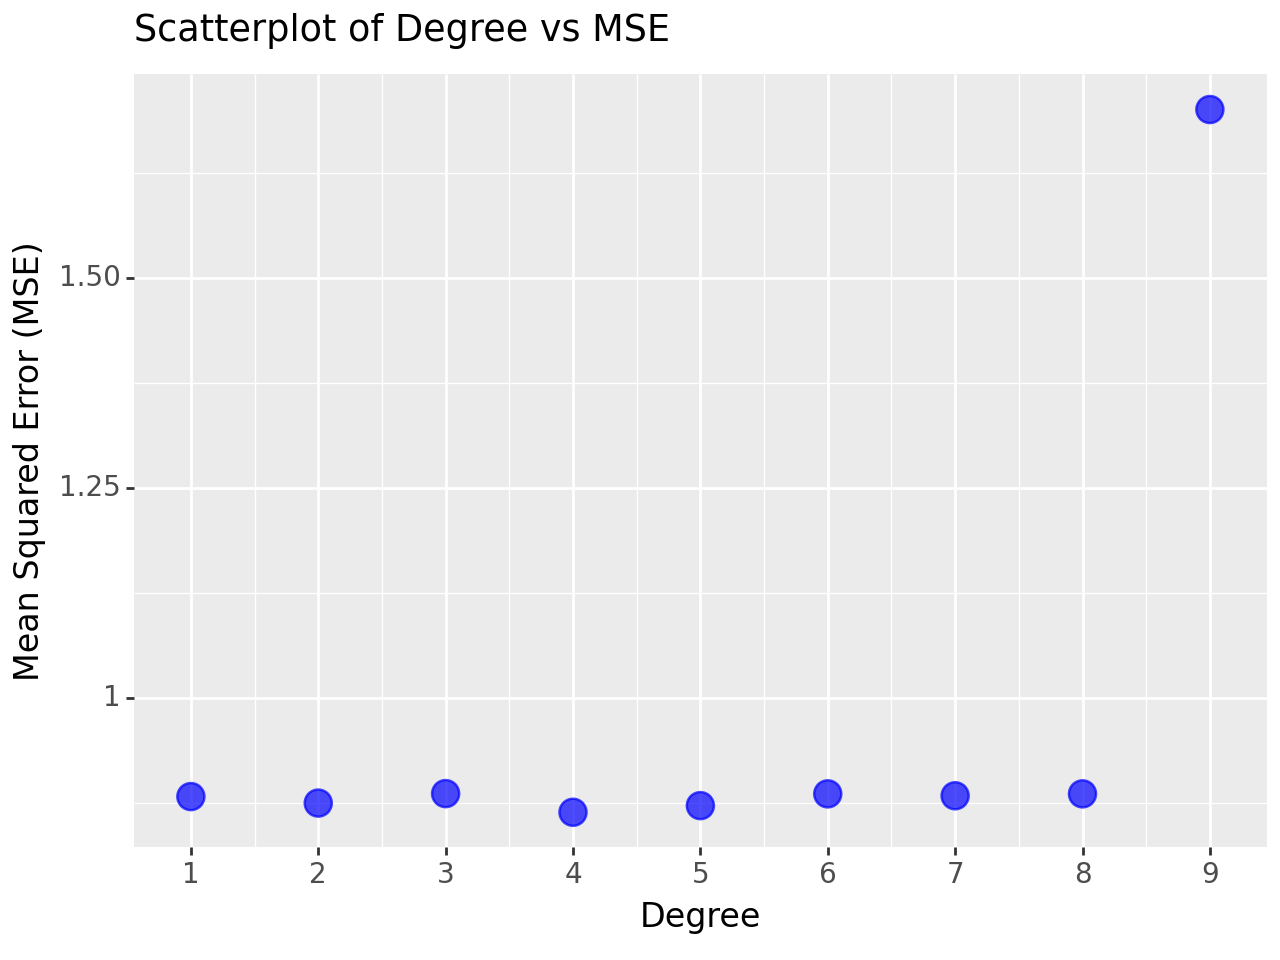

In [47]:
scatter_plot = (
    ggplot(linear_combos, aes(x='degree', y='mean_score')) +
    geom_point(size=5, color='blue', alpha=0.7) +
    labs(x='Degree', y='Mean Squared Error (MSE)', title='Scatterplot of Degree vs MSE') +
    theme(axis_text=element_text(size=10), axis_title=element_text(size=12)) +
    scale_x_continuous(breaks=list(range(1, len(linear_combos) + 1)), expand=(0.05, 0.05)) +
    scale_y_continuous(limits=[min(linear_combos['mean_score']), max(linear_combos['mean_score'])])
)

print(scatter_plot)

## KNN Models

In [48]:
knn_pipeline = Pipeline(
  [("preprocessing", ct),
  ("knn", KNeighborsRegressor(n_neighbors=5))]
)

In [49]:
param_knn = {
    'knn__n_neighbors': (1, 2, 3, 4, 5, 6, 10, 15, 25, 50, 100)
}

gscv = GridSearchCV(knn_pipeline, param_knn, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_

means = gscv_fitted.cv_results_['mean_test_score']

means = -means

In [50]:
gscv_fitted.cv_results_

params = gscv_fitted.cv_results_['params']

In [54]:
best_knn_combo = {'x': params, 'means': means}
best_knn_combo = pd.DataFrame(best_knn_combo)
pd.set_option('display.max_colwidth', None)
best_knn_combo = best_knn_combo.sort_values(by="means", ascending=True)
best_knn_combo.head(3)

,x,means
8,{'knn__n_neighbors': 25},4.721975
9,{'knn__n_neighbors': 50},4.835828
6,{'knn__n_neighbors': 10},4.837085


In [56]:
knn_table = pd.DataFrame({
    "K-values": [8, 9, 6, 7, 5, 4, 2,3, 1, 0],
    "MSE": [4.721975, 4.835828, 4.837085, 4.843958, 4.934383, 4.963356, 4.982032, 5.018196, 5.278764, 6.313764]
})

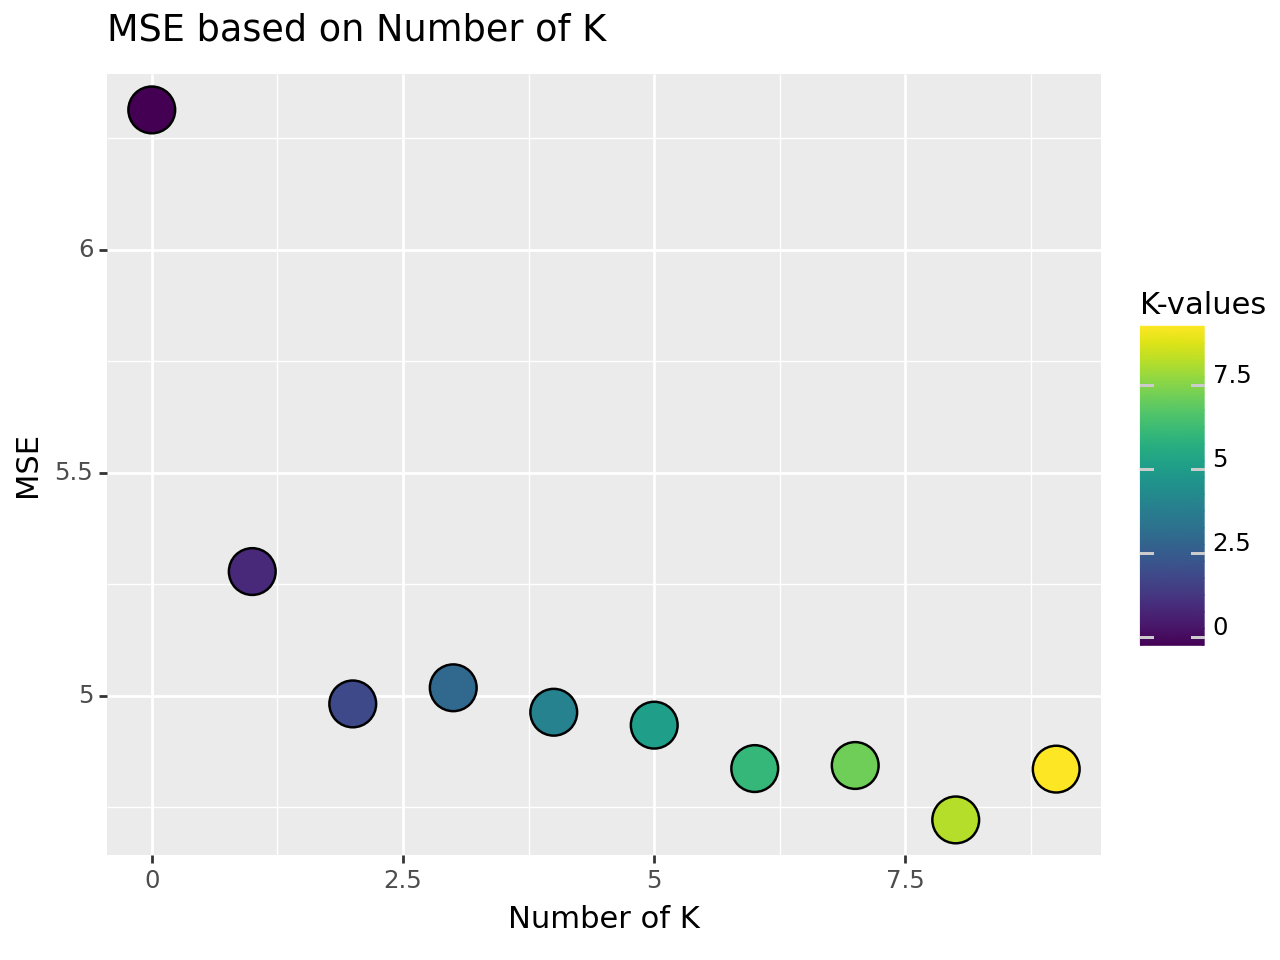

<Figure Size: (640 x 480)>

In [58]:
knn_plot = (ggplot(knn_table, aes(x = "K-values", y = "MSE", fill = "K-values"))
  +geom_point(size = 9)
  +xlab("Number of K")
  +ylab("MSE")
  +ggtitle("MSE based on Number of K"))

knn_plot

## Decision Tree

In [59]:
decision_tree_pipeline = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeRegressor(min_samples_leaf = 7))
])

In [61]:
param_decision_tree = {
    'decision_tree__min_samples_leaf': (1, 5, 10, 15, 30, 50, 200)
}

gscv = GridSearchCV(decision_tree_pipeline, param_decision_tree, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_

means = gscv_fitted.cv_results_['mean_test_score']

means = -means

gscv_fitted.cv_results_

params = gscv_fitted.cv_results_['params']

In [62]:
best_tree_combo = {'x': params, 'means': means}
best_tree_combo = pd.DataFrame(best_tree_combo)
pd.set_option('display.max_colwidth', None)
best_tree_combo = best_tree_combo.sort_values(by="means", ascending=True)
best_tree_combo

,x,means
3,{'decision_tree__min_samples_leaf': 15},0.811102
4,{'decision_tree__min_samples_leaf': 30},0.867419
2,{'decision_tree__min_samples_leaf': 10},0.868742
5,{'decision_tree__min_samples_leaf': 50},0.950212
1,{'decision_tree__min_samples_leaf': 5},1.004740
0,{'decision_tree__min_samples_leaf': 1},1.519641
6,{'decision_tree__min_samples_leaf': 200},5.194686


In [65]:
# Given output
output_data = {
    'x': [{'decision_tree__min_samples_leaf': 15},
          {'decision_tree__min_samples_leaf': 30},
          {'decision_tree__min_samples_leaf': 10},
          {'decision_tree__min_samples_leaf': 50},
          {'decision_tree__min_samples_leaf': 5},
          {'decision_tree__min_samples_leaf': 1},
          {'decision_tree__min_samples_leaf': 200}],
    'means': [0.811102, 0.867419, 0.868742, 0.950212, 1.004740, 1.519641, 5.194686]
}

# Extract only leaf sample values from 'x' column
leaf_samples_values = [list(combo.values())[0] for combo in output_data['x']]

# Create DataFrame
leaf_mse_df = pd.DataFrame({
    'leaf_samples': leaf_samples_values,
    'mse': output_data['means']
})

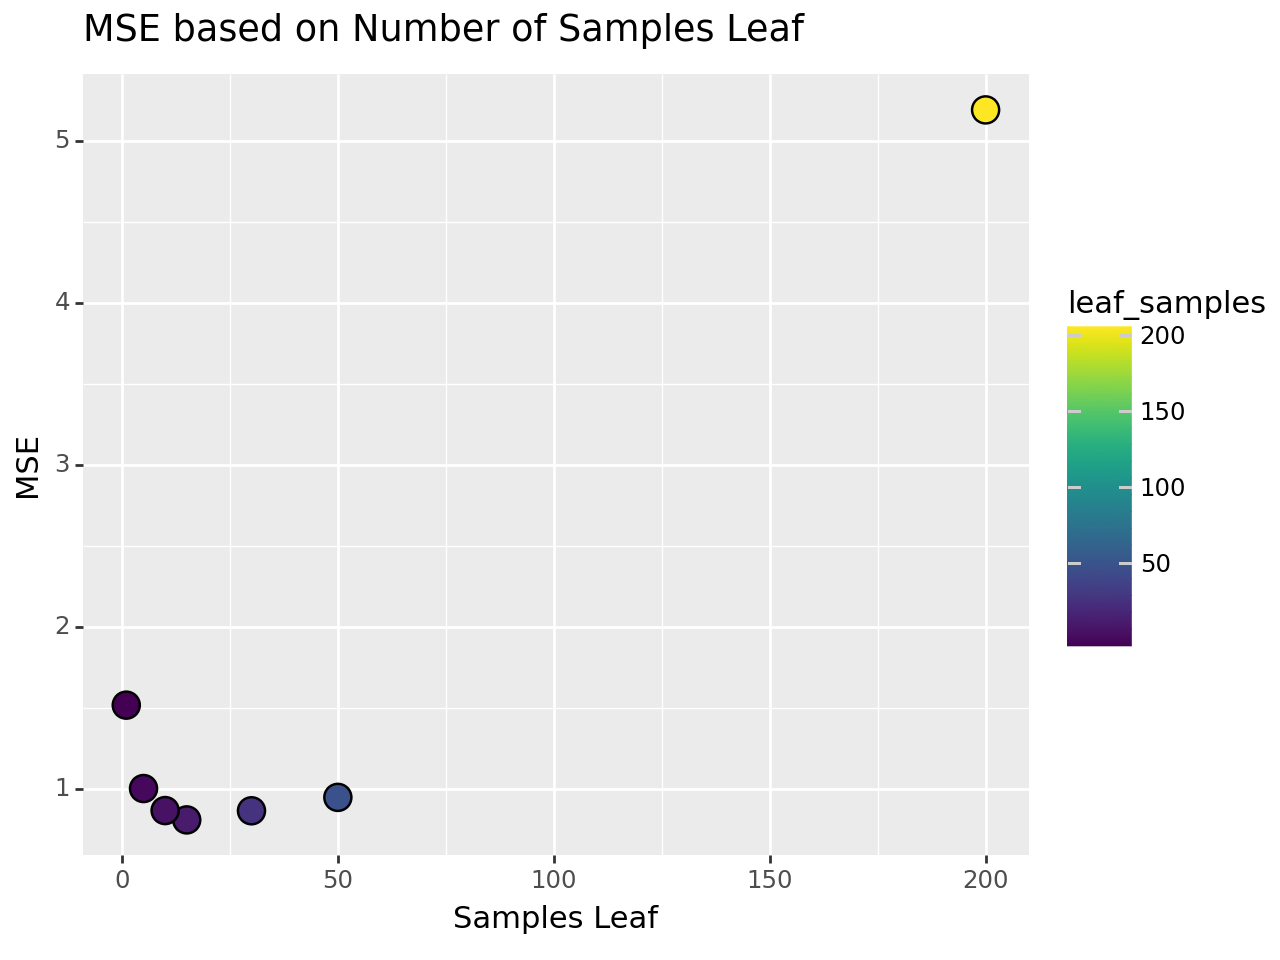

<Figure Size: (640 x 480)>

In [66]:
dt_plot = (ggplot(leaf_mse_df, aes(x = "leaf_samples", y = "mse", fill = "leaf_samples"))
  +geom_point(size = 5)
  +xlab("Samples Leaf")
  +ylab("MSE")
  +ggtitle("MSE based on Number of Samples Leaf"))

dt_plot